# Illustrating the functioning of the Particle Swarm Sampler on a 2D parameter space

In this notebook we will illustrate the functioning of the Particle Swarm sampler by using it to recover the mean and variance of a Normal distribution from a time series.

In [2]:
import numpy as np
from black_it.loss_functions.msm import MethodOfMomentsLoss

from black_it.search_space import SearchSpace

from black_it.samplers.particle_swarm import ParticleSwarmSampler

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from numpy.typing import NDArray
from typing import Sequence
from numpy.random import default_rng


Text(0, 0.5, 'value')

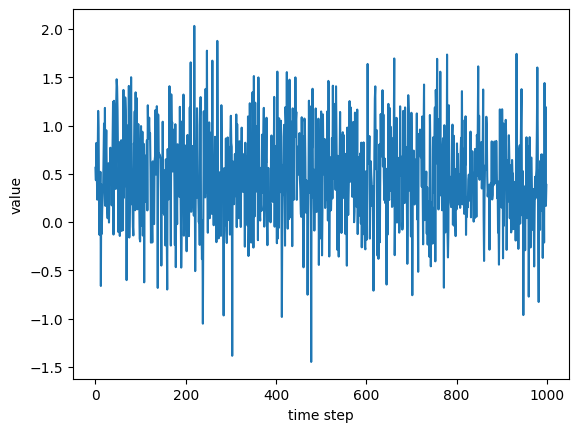

In [3]:
# target time series
def NormalMV(theta: Sequence[float], N: int, seed: int) -> NDArray[np.float64]:
    """Normal samples with adjustable mean and variance."""
    rng = default_rng(seed)
    y = rng.normal(theta[0], theta[1], N)
    return np.atleast_2d(y).T


true_params = [0.5, 0.5]  # in general these are not known!
real_data = NormalMV(true_params, 1000, 0)
plt.plot(real_data[:, 0])
plt.xlabel("time step")
plt.ylabel("value")

In [4]:
# define a 2-dimensional grid of possible parameter values between 0 and 1.
param_grid = SearchSpace(
    parameters_bounds=np.array([[0, 1], [0, 1]]).T,
    parameters_precision=[0.01, 0.01],
    verbose=False,
)

loss_function = MethodOfMomentsLoss()

In [7]:
# run 200 iterations of the particle swarm sampler with 5 particles
from collections import defaultdict

seed = 0
nb_iterations = 200
nb_ensemble = 1
N = 1000
batch_size = 5
sampler = ParticleSwarmSampler(batch_size=batch_size, random_state=seed,
                               c1=0.2,
                               c2=0.5,
                               inertia=0.8,
                               verbose=True)

points = np.zeros((0, 2))
losses = np.array([])

history_of_mins = []
particle_trajectory = defaultdict(lambda: [])

for i in range(nb_iterations):
    if i%10==0: print("Iteration ", i)
    current_positions = sampler.sample(param_grid, points, losses)
    current_losses = []
    for particle_id, point in enumerate(current_positions):
        outputs = []
        for ensemble in range(nb_ensemble):
            outputs.append(NormalMV(point, N, seed))
            seed += 1
        outputs = np.array(outputs).reshape((nb_ensemble, -1, 1))
        loss = loss_function.compute_loss(outputs, real_data)
        current_losses.append(loss)
        particle_trajectory[particle_id].append(point)
    points = np.concatenate([points, current_positions])
    losses = np.concatenate([losses, current_losses])

current_global_min_particle_id = None
current_global_min_loss = np.inf
for batch_id in range(nb_iterations):
    batch_points = points[batch_id * batch_size: (batch_id + 1) * batch_size]
    batch_losses = losses[batch_id * batch_size: (batch_id + 1) * batch_size]
    new_current_global_min_loss = np.min(batch_losses)
    new_current_global_min_particle_id = np.argmin(batch_losses)
    if new_current_global_min_loss < current_global_min_loss:
        current_global_min_particle_id = new_current_global_min_particle_id
        current_global_min_loss = new_current_global_min_loss
        history_of_mins.append(batch_points[current_global_min_particle_id])


Iteration  0
Iteration  10
Iteration  20
Iteration  30
Iteration  40
Iteration  50
Iteration  60
Iteration  70
Iteration  80
Iteration  90
Iteration  100
Iteration  110
Iteration  120
Iteration  130
Iteration  140
Iteration  150
Iteration  160
Iteration  170
Iteration  180
Iteration  190


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_54836/309461706.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(true_params[0], true_params[1], marker="x", s=500, facecolor="red", edgecolors='black', label="true global minima")


/Users/aldoglielmo/miniconda3/envs/py39_2/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/aldoglielmo/miniconda3/envs/py39_2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


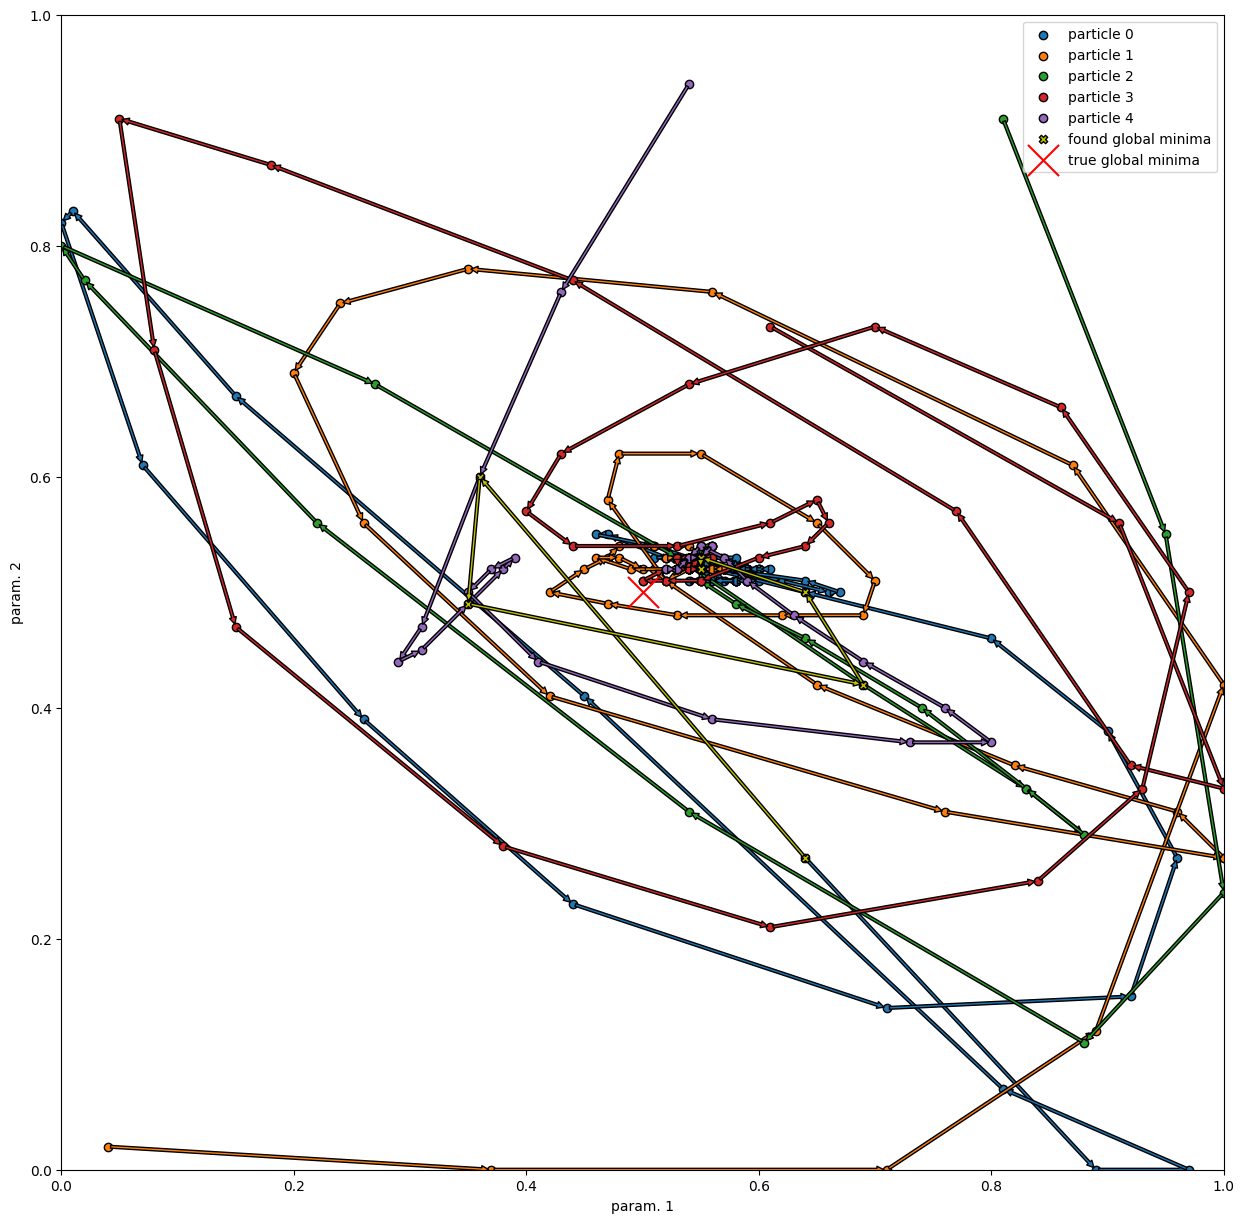

In [8]:
# plot the trajectories of the 5 particles, check that they gradually move towards the correct target value
fig = plt.figure(figsize=(15, 15))
axes = plt.axes()

def plot_trajectory(trajectory, axes, marker = "o", label=None, color=None):
    trajectory = np.array(trajectory)
    path_obj = axes.scatter(
        trajectory[:, 0],
        trajectory[:, 1],
        label=label,
        edgecolors='black',
        marker=marker,
        color=color
    )
    color = path_obj.get_facecolor()[0] if color is None else color
    for step_id in range(0, len(trajectory) - 1):
        p1, p2 = trajectory[step_id], trajectory[step_id+1]
        arrow = mpatches.FancyArrowPatch(p1, p2, facecolor=color, mutation_scale=10, edgecolor='black')
        axes.add_patch(arrow)

# plot trajectories
for particle_id, trajectory_i in particle_trajectory.items():
    plot_trajectory(trajectory_i, axes, label=f"particle {particle_id}")

# plot the history of global minimum
plot_trajectory(history_of_mins, axes, marker="X", color="y", label="found global minima")

# plot true parameters
plt.scatter(true_params[0], true_params[1], marker="x", s=500, facecolor="red", edgecolors='black', label="true global minima")


plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("param. 1")
plt.ylabel("param. 2")
plt.legend()

Text(0, 0.5, 'param. 2')

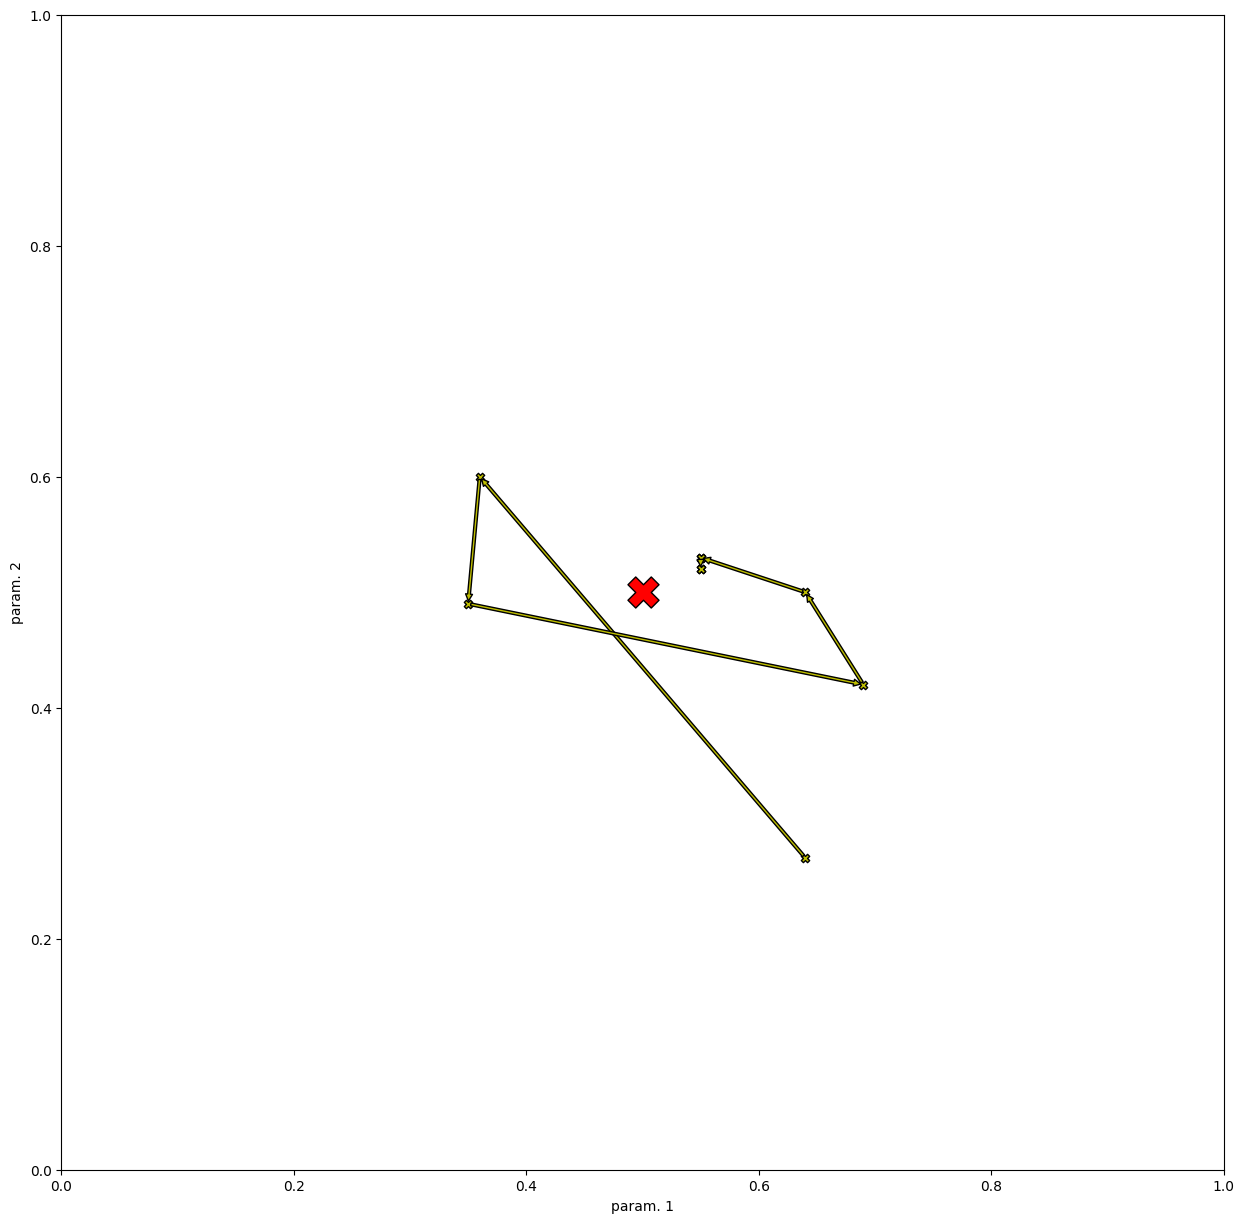

In [11]:
# only plot global minimums
fig = plt.figure(figsize=(15, 15))
axes = plt.axes()

# plot true parameters
plt.scatter(true_params[0], true_params[1], marker="X", s=500, facecolor="red", edgecolors='black')

# plot the history of global minimum
plot_trajectory(history_of_mins, axes, marker="X", color="y", label="global minima")


plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("param. 1")
plt.ylabel("param. 2")

In [12]:
print("Best parameter found: ", history_of_mins[-1])

Best parameter found:  [0.55 0.52]
